In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12          # 统一字号（可改）
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, f1_score,
    adjusted_rand_score, silhouette_score, confusion_matrix
)

from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

In [2]:
DATA_PATH = "migraine_symptom_classification.csv"
df = pd.read_csv(DATA_PATH)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# 标签分布
print("\nClass distribution (Type):")
print(df["Type"].value_counts())

Data shape: (400, 24)
Columns: ['Age', 'Duration', 'Frequency', 'Location', 'Character', 'Intensity', 'Nausea', 'Vomit', 'Phonophobia', 'Photophobia', 'Visual', 'Sensory', 'Dysphasia', 'Dysarthria', 'Vertigo', 'Tinnitus', 'Hypoacusis', 'Diplopia', 'Defect', 'Ataxia', 'Conscience', 'Paresthesia', 'DPF', 'Type']

Class distribution (Type):
Type
Typical aura with migraine       247
Migraine without aura             60
Familial hemiplegic migraine      24
Typical aura without migraine     20
Basilar-type aura                 18
Other                             17
Sporadic hemiplegic migraine      14
Name: count, dtype: int64


 Preprocessing

In [3]:
#1.1 删除常量列：Ataxia 在该CSV中只有1个取值（全0）
nunique = df.drop(columns=["Type"]).nunique()
const_cols = nunique[nunique <= 1].index.tolist()
print("\nConstant columns:", const_cols)


Constant columns: ['Ataxia']


In [4]:
# 特征列
feature_cols = [c for c in df.columns if c != "Type" and c not in const_cols]
X = df[feature_cols].copy()
y = df["Type"].copy()

print("\nUsing feature columns (p={}):".format(len(feature_cols)))
print(feature_cols)


Using feature columns (p=22):
['Age', 'Duration', 'Frequency', 'Location', 'Character', 'Intensity', 'Nausea', 'Vomit', 'Phonophobia', 'Photophobia', 'Visual', 'Sensory', 'Dysphasia', 'Dysarthria', 'Vertigo', 'Tinnitus', 'Hypoacusis', 'Diplopia', 'Defect', 'Conscience', 'Paresthesia', 'DPF']


In [5]:
#缺失值检查
missing = X.isna().sum().sum()
print("\nTotal missing values in X:", missing)


Total missing values in X: 0


In [6]:
#标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(float))

EFA适用性检验：KMO + Bartlett

In [7]:
chi2, pval = calculate_bartlett_sphericity(X_scaled)
kmo_all, kmo_model = calculate_kmo(X_scaled)

print("\nBartlett’s test: chi2={:.2f}, p={:.3e}".format(chi2, pval))
print("KMO overall: {:.3f}".format(kmo_model))


Bartlett’s test: chi2=2532.18, p=0.000e+00
KMO overall: 0.574


KMO有点低，挨个计算并剔除后再次对比

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer import calculate_kmo

# 计算KMO
kmo_all, kmo_model = calculate_kmo(X_scaled)

msa = pd.Series(kmo_all, index=feature_cols, name="MSA").sort_values()
print("Overall KMO:", round(kmo_model, 3))
print("\nBottom variables (lowest MSA):")
print(msa.head(10).round(3))

print("\nTop variables (highest MSA):")
print(msa.tail(10).round(3))

# 如果你想导出一份表写论文
msa.to_csv("msa_kmo_per_variable.csv", encoding="utf-8-sig")


Overall KMO: 0.574

Bottom variables (lowest MSA):
Nausea         0.339
Vomit          0.415
Dysarthria     0.450
Diplopia       0.490
Photophobia    0.498
Dysphasia      0.507
Defect         0.508
Tinnitus       0.511
Conscience     0.516
Paresthesia    0.523
Name: MSA, dtype: float64

Top variables (highest MSA):
Sensory        0.559
Duration       0.568
DPF            0.576
Location       0.585
Character      0.591
Vertigo        0.600
Age            0.618
Phonophobia    0.642
Visual         0.686
Intensity      0.809
Name: MSA, dtype: float64


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer import calculate_kmo


features = [c for c in df.columns if c != "Type" and c not in const_cols]
X0 = df[features].astype(float)

def compute_kmo(Xdf):
    X_scaled = StandardScaler().fit_transform(Xdf)
    kmo_all, kmo_model = calculate_kmo(X_scaled)
    msa = pd.Series(kmo_all, index=Xdf.columns, name="MSA").sort_values()
    return kmo_model, msa

kmo_model, msa = compute_kmo(X0)
print("Start overall KMO:", round(kmo_model, 3))

history = []
current_X = X0.copy()

# 你可以改阈值：0.50是常用的“剔除线”
THRESH = 0.50
MAX_DROP = 8  # 最多删几个，避免过度“修剪”导致解释性变差

for step in range(1, MAX_DROP + 1):
    kmo_model, msa = compute_kmo(current_X)
    worst_var = msa.index[0]
    worst_msa = msa.iloc[0]

    history.append({
        "step": step,
        "overall_kmo": kmo_model,
        "worst_var": worst_var,
        "worst_msa": worst_msa,
        "p": current_X.shape[1]
    })

    print(f"Step {step}: KMO={kmo_model:.3f}, worst={worst_var} (MSA={worst_msa:.3f}), p={current_X.shape[1]}")

    # 如果最差变量也不低于阈值，就停止
    if worst_msa >= THRESH:
        print("All variables have MSA >= threshold. Stop.")
        break

    # 删除最差变量
    current_X = current_X.drop(columns=[worst_var])

# 输出历史记录，方便你写论文“剔除策略与KMO改善”
hist_df = pd.DataFrame(history)
print("\nHistory:")
print(hist_df.round(3))

hist_df.to_csv("kmo_iterative_drop_history.csv", index=False, encoding="utf-8-sig")

# 最终保留下来的变量列表
kept_vars = current_X.columns.tolist()
pd.Series(kept_vars, name="kept_variables").to_csv("efa_kept_variables.csv", index=False, encoding="utf-8-sig")


Start overall KMO: 0.574
Step 1: KMO=0.574, worst=Nausea (MSA=0.339), p=22
Step 2: KMO=0.610, worst=Vomit (MSA=0.413), p=21
Step 3: KMO=0.614, worst=Dysarthria (MSA=0.457), p=20
Step 4: KMO=0.618, worst=Diplopia (MSA=0.498), p=19
Step 5: KMO=0.622, worst=Defect (MSA=0.490), p=18
Step 6: KMO=0.633, worst=Paresthesia (MSA=0.471), p=17
Step 7: KMO=0.636, worst=Duration (MSA=0.475), p=16
Step 8: KMO=0.639, worst=Frequency (MSA=0.496), p=15

History:
   step  overall_kmo    worst_var  worst_msa   p
0     1        0.574       Nausea      0.339  22
1     2        0.610        Vomit      0.413  21
2     3        0.614   Dysarthria      0.457  20
3     4        0.618     Diplopia      0.498  19
4     5        0.622       Defect      0.490  18
5     6        0.633  Paresthesia      0.471  17
6     7        0.636     Duration      0.475  16
7     8        0.639    Frequency      0.496  15


In [10]:
drop_vars = ["Nausea", "Vomit", "Dysarthria"]
X19 = X0.drop(columns=drop_vars)
X19_scaled = StandardScaler().fit_transform(X19)

因子数选择：碎石图 + 平行分析

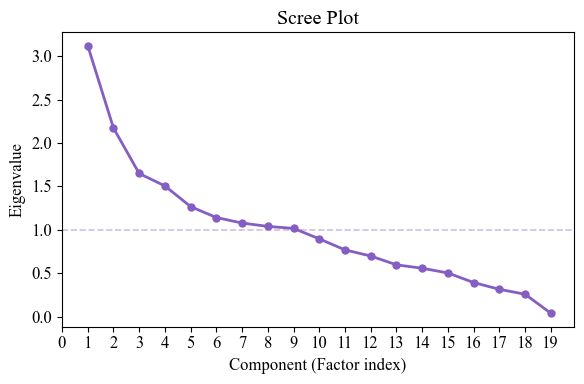

In [11]:
# 3.1 碎石图：用PCA特征值（对标准化数据等价于相关矩阵特征值）
pca_full = PCA()
pca_full.fit(X19_scaled)
eigs = pca_full.explained_variance_

color_main = "#845EC2"

plt.figure(figsize=(6,4))
plt.plot(range(1, len(eigs) + 1), eigs,
         marker="o",
         color=color_main,
         linewidth=2.0,
         markersize=5)

plt.axhline(1.0,
            linestyle="--",
            color=color_main,
            linewidth=1.2,
            alpha=0.4)

plt.title("Scree Plot")
plt.xlabel("Component (Factor index)")
plt.xticks(range(0, len(eigs) + 1, 1))
plt.ylabel("Eigenvalue")
plt.tight_layout()
plt.savefig("scree_plot.png", dpi=300)
plt.show()


Parallel Analysis suggests n_factors = 5


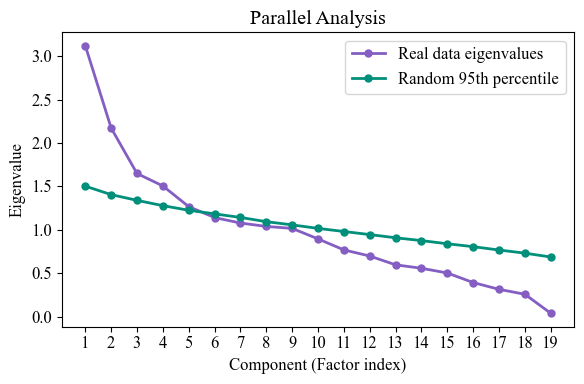

In [14]:
# 3.2 平行分析：随机数据特征值的95百分位作为阈值
def parallel_analysis(X, n_iter=200, percentile=95, random_state=0):
    rng = np.random.default_rng(random_state)
    n, p = X19_scaled.shape
    rand_eigs = np.zeros((n_iter, p))
    for i in range(n_iter):
        Z = rng.normal(size=(n, p))
        ev = PCA().fit(Z).explained_variance_
        rand_eigs[i, :] = ev
    thresh = np.percentile(rand_eigs, percentile, axis=0)
    real_eigs = PCA().fit(X).explained_variance_
    n_factors = int(np.sum(real_eigs > thresh))
    return n_factors, real_eigs, thresh

n_factors_pa, real_eigs, rand_thresh = parallel_analysis(
    X19_scaled, n_iter=200, percentile=95, random_state=42
)
print("\nParallel Analysis suggests n_factors =", n_factors_pa)
color_real = "#845EC2"
color_rand = "#008f7a"

plt.figure(figsize=(6,4))

plt.plot(range(1, len(real_eigs) + 1), real_eigs,
         marker="o", linewidth=2.0, markersize=5,
         color=color_real, label="Real data eigenvalues")

plt.plot(range(1, len(rand_thresh) + 1), rand_thresh,
         marker="o", linewidth=2.0, markersize=5,
         color=color_rand, label="Random 95th percentile")

plt.title("Parallel Analysis")
plt.xlabel("Component (Factor index)")
plt.ylabel("Eigenvalue")

plt.xticks(range(1, len(real_eigs) + 1, 1))

plt.legend()
plt.tight_layout()
plt.savefig("parallel_analysis.png", dpi=300)
plt.show()


 EFA建模（Promax斜交旋转更贴合症状维度可能相关）

In [18]:
fa = FactorAnalyzer(n_factors=n_factors_pa, rotation="promax", method="principal")
fa.fit(X19_scaled)

feature_cols = df.columns[:19]  # 确保索引与特征数量一致
loadings = pd.DataFrame(
    fa.loadings_,
    index=feature_cols,
    columns=[f"Factor{i+1}" for i in range(n_factors_pa)]
)

d:\Anaconda\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
var, prop_var, cum_var = fa.get_factor_variance()
print("\nEFA variance explained (proportion):", np.round(prop_var, 4))
print("EFA cumulative variance:", np.round(cum_var, 4))


EFA variance explained (proportion): [0.1559 0.0977 0.1188 0.0963 0.0704]
EFA cumulative variance: [0.1559 0.2536 0.3724 0.4686 0.5391]


In [22]:
# 输出：每个因子Top载荷变量（便于写论文）
def top_loadings_table(load_df, topn=6, thresh=0.35):
    tables = {}
    for f in load_df.columns:
        s = load_df[f].copy()
        s_abs = s.abs()
        s2 = pd.DataFrame({"loading": s, "abs": s_abs}).sort_values("abs", ascending=False)
        s2 = s2[s2["abs"] >= thresh].head(topn)
        tables[f] = s2[["loading"]]
    return tables

top_tables = top_loadings_table(loadings, topn=6, thresh=0.35)
print("\nTop loadings per factor (|loading|>=0.35):")
for f, t in top_tables.items():
    print("\n===", f, "===")
    print(t.round(5))


Top loadings per factor (|loading|>=0.35):

=== Factor1 ===
             loading
Intensity    0.87932
Location     0.86287
Character    0.85341
Phonophobia -0.66795

=== Factor2 ===
            loading
Dysphasia   0.80332
Visual      0.60314
Dysarthria  0.50006
Hypoacusis  0.46577
Sensory     0.38090

=== Factor3 ===
           loading
Nausea     0.90724
Vomit      0.88608
Character -0.50449

=== Factor4 ===
          loading
Tinnitus  0.83849
Vertigo   0.54229
Diplopia  0.48686
Sensory   0.43970

=== Factor5 ===
           loading
Frequency  0.74455
Duration   0.66031


In [20]:
# 因子得分
F_scores = fa.transform(X19_scaled)  # shape (n, n_factors)

d:\Anaconda\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


C:\Users\Zhang\AppData\Local\Temp\ipykernel_28240\3969979753.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 5000x5000 with 0 Axes>

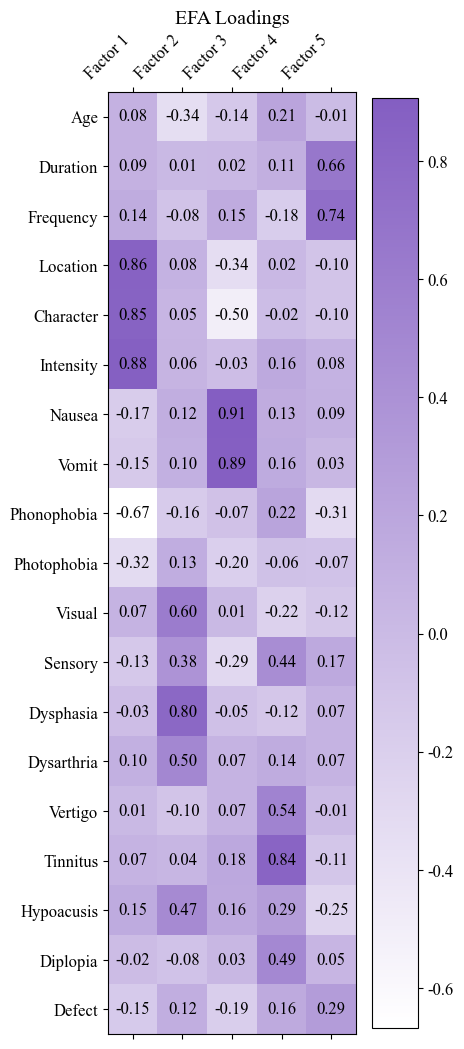

In [51]:
# Create a custom colormap using #845ec2
cmap = mcolors.LinearSegmentedColormap.from_list("custom_purple", ["#ffffff", "#845ec2"], N=256)

# Assuming `fa.loadings_` has the shape (n_features, n_factors), and the correct index and columns
loadings = pd.DataFrame(fa.loadings_, columns=[f"Factor {i+1}" for i in range(n_factors_pa)], index=df.columns[:19])

# Create a figure and axis with a larger figure size to ensure all content fits
plt.figure(figsize=(50, 50))  # Increase figure size

# Display the matrix as a heatmap with the custom colormap
cax = plt.matshow(loadings, cmap=cmap)

# Add color bar
plt.colorbar(cax)

# Add title and labels
plt.title("EFA Loadings")
plt.xticks(np.arange(len(loadings.columns)), loadings.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(loadings.index)), loadings.index)

# Annotate with the values
for i in range(len(loadings.index)):
    for j in range(len(loadings.columns)):
        plt.text(j, i, f'{loadings.iloc[i, j]:.2f}', ha='center', va='center', color='black')

# Adjust layout to ensure everything fits
plt.tight_layout()

# Optionally, adjust the spacing between subplots to avoid cutting off labels
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the figure with a higher resolution
plt.savefig("efa_loadings.png", dpi=300)

# Show the plot
plt.show()


PCA对照（同维度 n_factors，保证公平）

In [33]:
pca = PCA(n_components=n_factors_pa, random_state=42)
X19_pca = pca.fit_transform(X19_scaled)

print("\nPCA explained variance ratio:", np.round(pca.explained_variance_ratio_, 4))
print("PCA cumulative explained variance:", np.round(np.sum(pca.explained_variance_ratio_), 4))



PCA explained variance ratio: [0.1637 0.114  0.0866 0.0791 0.0666]
PCA cumulative explained variance: 0.51


C:\Users\Zhang\AppData\Local\Temp\ipykernel_28240\2947297729.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 2000x3000 with 0 Axes>

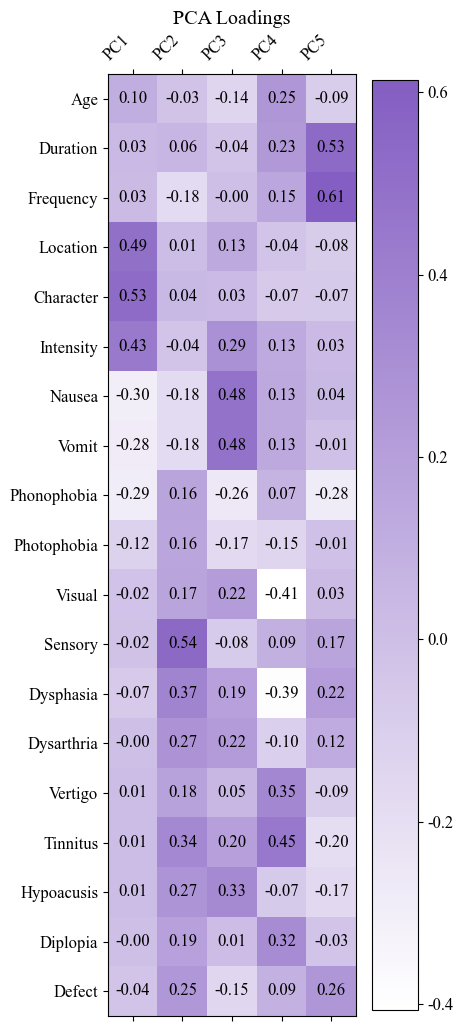

In [50]:
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(5)], index=df.columns[:19])

# 创建自定义的紫色渐变色
cmap = mcolors.LinearSegmentedColormap.from_list("custom_purple", ["#ffffff", "#845ec2"], N=256)

# 创建一个图形和轴
plt.figure(figsize=(20, 30))

# 显示PCA载荷矩阵，使用matshow绘制热力图，应用自定义的colormap
cax = plt.matshow(pca_loadings, cmap=cmap)

# 添加颜色条
plt.colorbar(cax)

# 添加标题和标签
plt.title("PCA Loadings")

# 为每个单元格添加注释
for i in range(len(pca_loadings.index)):
    for j in range(len(pca_loadings.columns)):
        plt.text(j, i, f'{pca_loadings.iloc[i, j]:.2f}', ha='center', va='center', color='black')

# 调整布局以防止标签重叠
plt.xticks(np.arange(len(pca_loadings.columns)), pca_loadings.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(pca_loadings.index)), pca_loadings.index)

# 调整布局以防止重叠
plt.tight_layout()
plt.savefig("pca_loadings.png", dpi=300)
plt.show()

聚类对照：KMeans（统一输入：Raw / PCA / EFA）

In [49]:
# 统一指标：Silhouette（内部） + ARI（外部对齐标签）
K = y.nunique()  # 用真实类别数做簇数（课程报告最直观）
print("\nClustering with K =", K)

def kmeans_eval(X_feat, y_true, name):
    km = KMeans(n_clusters=K, random_state=42, n_init=20)
    labels = km.fit_predict(X_feat)
    ari = adjusted_rand_score(y_true, labels)
    sil = silhouette_score(X_feat, labels)
    print(f"{name}: ARI={ari:.3f}, Silhouette={sil:.3f}")
    return ari, sil

ari_raw, sil_raw = kmeans_eval(X_scaled, y, "KMeans on Raw")
ari_pca, sil_pca = kmeans_eval(X_pca, y, "KMeans on PCA scores")
ari_efa, sil_efa = kmeans_eval(F_scores, y, "KMeans on EFA scores")


Clustering with K = 7


d:\Anaconda\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans on Raw: ARI=0.626, Silhouette=0.148
KMeans on PCA scores: ARI=0.370, Silhouette=0.285


d:\Anaconda\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Anaconda\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans on EFA scores: ARI=0.352, Silhouette=0.304


LDA分类对照（统一设置：5折分层CV）

In [50]:
# 统一指标：Accuracy + Macro-F1
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def lda_cv_eval(X_feat, y_true, name):
    clf = LinearDiscriminantAnalysis()
    y_pred = cross_val_predict(clf, X_feat, y_true, cv=skf)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"{name}: CV Accuracy={acc:.3f}, Macro-F1={f1:.3f}")
    return acc, f1, y_pred

acc_raw, f1_raw, pred_raw = lda_cv_eval(X_scaled, y, "LDA on Raw")
acc_pca, f1_pca, pred_pca = lda_cv_eval(X_pca, y, "LDA on PCA scores")
acc_efa, f1_efa, pred_efa = lda_cv_eval(F_scores, y, "LDA on EFA scores")

# （可选）输出一个混淆矩阵（建议只给EFA版，论文更聚焦）
cm = confusion_matrix(y, pred_efa, labels=y.unique())
print("\nConfusion matrix (LDA on EFA scores) - rows=true, cols=pred:")
print(pd.DataFrame(cm, index=y.unique(), columns=y.unique()))


LDA on Raw: CV Accuracy=0.877, Macro-F1=0.743
LDA on PCA scores: CV Accuracy=0.868, Macro-F1=0.763
LDA on EFA scores: CV Accuracy=0.868, Macro-F1=0.763

Confusion matrix (LDA on EFA scores) - rows=true, cols=pred:
                               Typical aura with migraine  \
Typical aura with migraine                            237   
Migraine without aura                                  10   
Basilar-type aura                                       0   
Sporadic hemiplegic migraine                            6   
Familial hemiplegic migraine                           12   
Other                                                   2   
Typical aura without migraine                           0   

                               Migraine without aura  Basilar-type aura  \
Typical aura with migraine                         6                  0   
Migraine without aura                             50                  0   
Basilar-type aura                                  0                 14 

In [51]:

# =========================
summary = pd.DataFrame({
    "Representation": ["Raw", "PCA(scores)", "EFA(scores)"],
    "KMeans ARI": [ari_raw, ari_pca, ari_efa],
    "KMeans Silhouette": [sil_raw, sil_pca, sil_efa],
    "LDA CV Accuracy": [acc_raw, acc_pca, acc_efa],
    "LDA Macro-F1": [f1_raw, f1_pca, f1_efa]
})
print("\n=== Summary Table ===")
print(summary.round(3))


=== Summary Table ===
  Representation  KMeans ARI  KMeans Silhouette  LDA CV Accuracy  LDA Macro-F1
0            Raw       0.626              0.148            0.878         0.743
1    PCA(scores)       0.370              0.285            0.868         0.763
2    EFA(scores)       0.352              0.304            0.868         0.763
